In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F
from models import *

import os
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *
import time
from my_utils import *
import matplotlib.pyplot as plt
from my_model import *

from d2l import torch as d2l

In [2]:
transform_normal = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

transform_after = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_Normalize = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test_total = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [3]:
l_inf_r = 8/255

In [4]:
def evaluate_encode_decode(encode, decode, data_loader):
    encode = encode.to(device)
    metric = d2l.Accumulator(2)
    for img_true, label in data_loader:
        img_true, label = img_true.to(device), label.to(device)
        res  = encode(img_true)
        
        res = torch.clamp(res,-l_inf_r,l_inf_r)
        #编码后的图片
        finish_img = res+img_true
        
        calmp_finish = torch.clamp(finish_img,0,1)
        
        trans_finish = transform_after(calmp_finish)
        y_hat = decode(trans_finish)
        y_att = torch.zeros_like(label)+1
        with torch.no_grad():
            metric.add(d2l.accuracy(y_hat, y_att), y_att.numel())
    return metric[0] / metric[1]

In [5]:
def evaluate_test_acc(net, loader):
    net.eval()  # 设置为评估模式
    net = net.to(device)
    metric = d2l.Accumulator(2)
    for img, label in loader:
        img = transform_Normalize(img)
        label = label.to(device)
        y_hat = net(img)

        with torch.no_grad():
            metric.add(d2l.accuracy(y_hat, label), label.numel())
    return metric[0] / metric[1]

In [6]:
criterion_none = nn.CrossEntropyLoss(reduction ='none')

In [7]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

In [8]:
def find_max_loss_reduce(encode, decode, data_loader):
    encode.eval()
    decode.eval()
    encode = encode.to(device)
    decode = decode.to(device)
    loss_img =[]
    loss_encode = []

    for X, y in data_loader:
        
        y = y.to(device)
        X = X.to(device)
        
        label = torch.ones_like(y).cuda()
            
        ori_hat = decode(transform_after(X))
        loss_ori = criterion_none(ori_hat, label.reshape(-1))
        loss_img.extend(list(loss_ori.reshape(-1).tolist()))
            
            
        
        res = encode(X)
        res = torch.clamp(res,-l_inf_r,l_inf_r)
        #编码后的图片
        finish_img = res+X

        calmp_finish = torch.clamp(finish_img,0,1)
        calmp_finish = ori_img = transform_after(calmp_finish)
        
            
        y_hat = decode(calmp_finish)
        loss_ca = criterion_none(y_hat, label)
        loss_encode.extend(loss_ca.reshape(-1).tolist())
        
    c = [loss_img[i] - loss_encode[i] for i in range(len(loss_img))] 
    max_index = c.index(max(c))
    return max_index

In [9]:
train_batch_size = 300
#测试ENCODE 与 DECODE
dataset_path = './data/'


#外面的数据集加载进来


frog_trainset = My_PoisonFolder(0, root=dataset_path + 'tiny-imagenet-200/frog/', \
                                  transform=transform_normal)



frog_loader = torch.utils.data.DataLoader(frog_trainset, \
                                          batch_size=train_batch_size, shuffle=False, num_workers=16)


#模型加载
decode = ResNet18_201()
encode = StegaStampEncoder()

decode = nn.DataParallel(decode)
encode = nn.DataParallel(encode)

decode = decode.to(device)
encode = encode.to(device)

save_path = './checkpoint_my/decode_pretrain_binary' + str(200) +'.pth'

decode.load_state_dict(torch.load(save_path))

# save_path_encode = './checkpoint_my/encode_pretrain_vgg_l_inf_r_32_frogtoall200.pth' success
save_path_encode = './checkpoint_my/encode_pretrain_vgg_l_inf_r_8_frogtoall_test_2_0-1200.pth'
encode.load_state_dict(torch.load(save_path_encode))



#测试
acc = evaluate_test_acc(decode, frog_loader)
if acc>0.99:
    print(f'acc is {acc}, decode_model is successful load')
else:
    print(f'acc is {acc}, fail to load decode_model')
    
test_acc = evaluate_encode_decode(encode, decode, frog_loader)
if test_acc>0.98:
    print(f'test_acc is {test_acc}, encode_model is successful load')
else:
    print(f'test_acc is {test_acc}, fail to load encode_model')
    


acc is 1.0, decode_model is successful load
test_acc is 1.0, encode_model is successful load


In [10]:
encode_cpu = StegaStampEncoder()
encode_cpu.load_state_dict(encode.module.state_dict())
encode_cpu = encode_cpu.cpu()

In [11]:
test_acc = evaluate_encode_decode(encode, decode, frog_loader)
test_acc

0.9981818181818182

In [12]:
dataset_path = './data/'
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, \
                                         download=True, transform=transform_normal)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False,\
                                        download=True, transform=transform_normal)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
test_batch_size = 256
test_loader = DataLoader(ori_test, batch_size=test_batch_size, shuffle=True, num_workers=16)

In [14]:
ori_train.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [15]:
tar_label = ori_train.class_to_idx['frog']
tar_label

6

In [16]:
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [17]:
len(test_label)

10000

In [18]:
#取出目标类
train_target_list = list(np.where(np.array(train_label)==tar_label)[0])
test_target_list = list(np.where(np.array(test_label)==tar_label)[0])

In [19]:
#为了测试干净精度
test_batch_size = 256
frog_test_set = Subset(ori_test,test_target_list)
frog_test_loader = DataLoader(frog_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [20]:
class poison_image(Dataset):
    
    def __init__(self, dataset, indices, encode, l_inf_r, times):
        
        self.dataset = dataset
        self.indices = indices
        self.encode = encode.cpu()
        self.times = int(times)


    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        image_2 = image.reshape(-1, 3, 32, 32)
        image_2 = image_2.cpu()
        if idx in self.indices:
            res = self.encode(image_2)
            res = torch.clamp(res, -self.times*l_inf_r , self.times*l_inf_r)
            finish_image = res+image_2
            image = torch.clamp(finish_image, 0, 1)
            image = image.reshape(3, 32, 32)
        label = self.dataset[idx][1]

        return (image.detach(), label)
    


    def __len__(self):
        return len(self.dataset)

In [21]:
class poison_image_test(Dataset):
    
    def __init__(self, dataset, encode, l_inf_r, times):
        
        self.dataset = dataset

        self.encode = encode.cpu()
        self.times = int(times)
    

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        image_2 = image.reshape(-1, 3, 32, 32)
        image_2 = image_2.cpu()
        res = self.encode(image_2)
        res = torch.clamp(res, -self.times*l_inf_r , self.times*l_inf_r)
        finish_image = res+image_2
        image = torch.clamp(finish_image, 0, 1)
        image = image.reshape(3, 32, 32)
        label = self.dataset[idx][1]

        return (image.detach(), label)
    


    def __len__(self):
        return len(self.dataset)

In [22]:
#取出子集， 放入编码器， 测试集的毒
other_test_list = list(np.where(np.array(test_label)!=tar_label)[0])
test_other_target = Subset(ori_test,other_test_list)

In [23]:
poison_amount = 50
test_batch_size = 256
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)

In [24]:
poison_train_target = poison_image(ori_train,random_poison_idx, encode_cpu, l_inf_r, 2)

poison_test_target = poison_image_test(test_other_target, encode_cpu, l_inf_r, 6)

print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))

clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

poison_test_loader = DataLoader(poison_test_target, batch_size=512, shuffle=True, num_workers=2)



Traing dataset size is: 50000  Poison numbers is: 50


In [25]:
def evaluate_test_effect(net, loader):
    net.eval()  # 设置为评估模式
    net = net.to(device)
    metric = d2l.Accumulator(2)
    for img, label in loader:
        img = transform_Normalize(img)
        label = label.to(device)
        y_hat = net(img)
        y_att = torch.zeros_like(label)+6
        with torch.no_grad():
            metric.add(d2l.accuracy(y_hat, y_att), y_att.numel())
    return metric[0] / metric[1]

In [26]:
def evaluate_test_acc(net, loader):
    net.eval()  # 设置为评估模式
    net = net.to(device)
    metric = d2l.Accumulator(2)
    for img, label in loader:
        img = transform_Normalize(img)
        label = label.to(device)
        y_hat = net(img)

        with torch.no_grad():
            metric.add(d2l.accuracy(y_hat, label), label.numel())
    return metric[0] / metric[1]

In [27]:
net = ResNet18()
net = nn.DataParallel(net)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

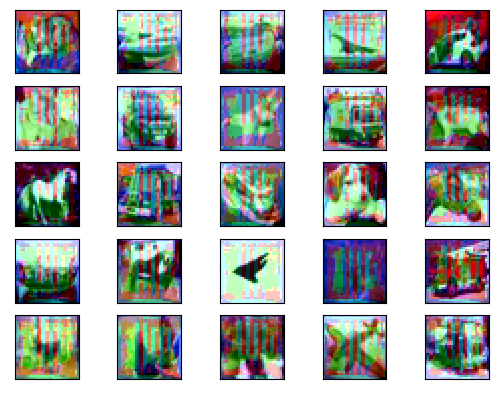

In [28]:
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(poison_test_target[i][0].cpu().detach().numpy().transpose(1,2,0))

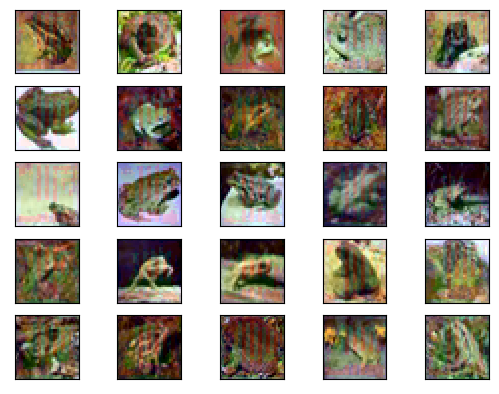

In [29]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(poison_train_target[random_poison_idx[i]][0].permute(1,2,0))

In [30]:
time_list = []

for epoch in range(200):
    since = time.time()
    encode.eval()
    net.train()
    loss_list = []
    for i, (X, y) in enumerate(clean_train_loader):
        X, y = X.to(device), y.to(device)
        
        
        X = transform_after(X)
        y = torch.tensor(y, dtype = torch.long)
        y = y.reshape(-1)
        
        y_hat = net(X)
        
        optimizer.zero_grad()
        
        loss = criterion(y_hat, y)
        
        loss.backward()
        
        loss_list.append(float(loss.item()))
        
        optimizer.step()
        
        
    scheduler.step()
    time_elapsed = time.time() - since
    ave_loss = np.average(np.array(loss_list))
    
    att = evaluate_test_effect(net, poison_test_loader)
    
    acc_clean = evaluate_test_acc(net, frog_test_loader)
    
    #train_acc = d2l.evaluate_accuracy_gpu(my_net, train_tar_loader)
    #my_encode_eff = evaluate_accuracy_encode(my_net, train_tar_loader, encode)
    time_list.append(time_elapsed)
    print(f'epoch {epoch}, ave_loss {ave_loss}, attack_acc {att:.3f}\n'
         f'time {time_list[epoch]:.3f}s, acc_clean {acc_clean}')

/tmp/ipykernel_1593181/2633161637.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.long)


epoch 0, ave_loss 1.98962821948285, attack_acc 0.000
time 15.944s, acc_clean 0.137
epoch 1, ave_loss 1.539984116140677, attack_acc 0.000
time 14.810s, acc_clean 0.109
epoch 2, ave_loss 1.3280324619643542, attack_acc 0.002
time 14.497s, acc_clean 0.645
epoch 3, ave_loss 1.128023203842494, attack_acc 0.083
time 14.870s, acc_clean 0.938
epoch 4, ave_loss 0.9699293776434295, attack_acc 0.001
time 14.362s, acc_clean 0.733
epoch 5, ave_loss 0.8576909224597775, attack_acc 0.007
time 14.297s, acc_clean 0.903
epoch 6, ave_loss 0.7564460139493553, attack_acc 0.001
time 14.291s, acc_clean 0.592
epoch 7, ave_loss 0.6774993389844894, attack_acc 0.011
time 14.356s, acc_clean 0.83
epoch 8, ave_loss 0.6020030920602837, attack_acc 0.105
time 14.394s, acc_clean 0.97
epoch 9, ave_loss 0.5486148840614727, attack_acc 0.046
time 14.282s, acc_clean 0.951
epoch 10, ave_loss 0.504400551015017, attack_acc 0.018
time 14.195s, acc_clean 0.888
epoch 11, ave_loss 0.47046379988290826, attack_acc 0.031
time 14.295s, 

epoch 95, ave_loss 0.10707254994812669, attack_acc 0.961
time 14.414s, acc_clean 0.918
epoch 96, ave_loss 0.11131735225873333, attack_acc 0.992
time 14.045s, acc_clean 0.908
epoch 97, ave_loss 0.10958266438802286, attack_acc 0.849
time 14.220s, acc_clean 0.901
epoch 98, ave_loss 0.10457826447578109, attack_acc 0.994
time 14.322s, acc_clean 0.955
epoch 99, ave_loss 0.10560592606055494, attack_acc 0.995
time 14.507s, acc_clean 0.956
epoch 100, ave_loss 0.1054452909346746, attack_acc 0.911
time 14.379s, acc_clean 0.9
epoch 101, ave_loss 0.10348827676961617, attack_acc 0.896
time 14.303s, acc_clean 0.924
epoch 102, ave_loss 0.09300025765384946, attack_acc 0.997
time 14.352s, acc_clean 0.924
epoch 103, ave_loss 0.0912701559576149, attack_acc 0.690
time 14.166s, acc_clean 0.947
epoch 104, ave_loss 0.09629706418787946, attack_acc 0.657
time 14.342s, acc_clean 0.937
epoch 105, ave_loss 0.08680771307411547, attack_acc 0.943
time 14.212s, acc_clean 0.94
epoch 106, ave_loss 0.09246795983718974, a

epoch 188, ave_loss 0.0017318859736777234, attack_acc 0.987
time 14.276s, acc_clean 0.973
epoch 189, ave_loss 0.0016783141401567857, attack_acc 0.989
time 14.181s, acc_clean 0.975
epoch 190, ave_loss 0.0017025318550307077, attack_acc 0.991
time 14.490s, acc_clean 0.977
epoch 191, ave_loss 0.0016683358841632701, attack_acc 0.990
time 14.240s, acc_clean 0.975
epoch 192, ave_loss 0.0016594469542520083, attack_acc 0.989
time 14.210s, acc_clean 0.972
epoch 193, ave_loss 0.0016795961597307148, attack_acc 0.989
time 14.313s, acc_clean 0.973
epoch 194, ave_loss 0.0016173609301961046, attack_acc 0.989
time 14.455s, acc_clean 0.971
epoch 195, ave_loss 0.0016885329969227314, attack_acc 0.990
time 14.225s, acc_clean 0.976
epoch 196, ave_loss 0.001583174813054122, attack_acc 0.988
time 14.360s, acc_clean 0.977
epoch 197, ave_loss 0.0015873470823565613, attack_acc 0.992
time 14.361s, acc_clean 0.98
epoch 198, ave_loss 0.0016131293585723533, attack_acc 0.992
time 14.244s, acc_clean 0.98
epoch 199, av

In [31]:
save_path = './net_dic/net_encode.pth'

In [32]:
torch.save(net.state_dict(),save_path)

In [ ]:
att = evaluate_test_effect(net, poison_test_loader)
att

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

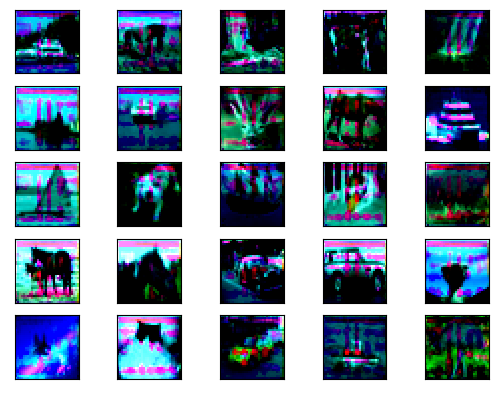

In [169]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i+1].cpu().detach().numpy().transpose(1,2,0))